In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import matplotlib.patches as patches
from torch.utils.data import DataLoader

In [3]:
sys.path.append(os.path.abspath("../src/text_detector_model"))

In [4]:
from dataset import DocumentDataset
from train import train_model
from model import get_faster_rcnn_model

In [5]:
data_version = "20250410185834"
batch_size = 32
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((724, 512)),
    transforms.ToTensor()
])

# Load data
documents_dir = Path(f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_19/{data_version}/")

In [6]:
train_dataset = DocumentDataset(images_dir=documents_dir / "train", annotation_file=documents_dir / "train_labels.json", transform=transform)
test_val_dataset = DocumentDataset(images_dir=documents_dir / "test", annotation_file=documents_dir / "test_labels.json", transform=transform)

# Split into val/test
val_size = int(0.5 * len(test_val_dataset))
test_size = len(test_val_dataset) - val_size

val_dataset, test_dataset = torch.utils.data.random_split(
    test_val_dataset, [val_size, test_size]
)

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [7]:
img = train_dataset[0][0]
label = train_dataset[0][1]

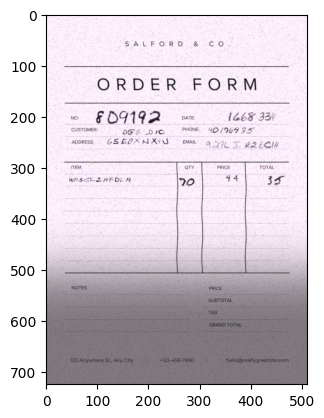

In [8]:
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.show()

In [9]:
label

{'boxes': tensor([[  97.,  705.,  372.,  728.],
         [ 785.,  422., 1004.,  464.],
         [ 570.,  706.,  643.,  745.],
         [ 950.,  696., 1047.,  741.],
         [ 212.,  414.,  507.,  476.],
         [ 326.,  497.,  525.,  523.],
         [ 699.,  488.,  904.,  517.],
         [ 773.,  693.,  830.,  726.],
         [ 688.,  548., 1004.,  581.],
         [ 261.,  535.,  539.,  564.]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [10]:
# Initialize model
model = get_faster_rcnn_model(len(train_dataset.classes) + 1)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [ ]:
trained_model = train_model(model, train_loader, optimizer, device, num_epochs=1)

Epoch 1/1
Loss: 14.1526


In [88]:
trained_model = train_model(trained_model, train_loader, optimizer, device, num_epochs=3)

Epoch 1/3
Loss: 3.1819
Epoch 2/3
Loss: 3.0820
Epoch 3/3
Loss: 3.0661


In [ ]:
trained_model = train_model(trained_model, train_loader, optimizer, device, num_epochs=3)

Epoch 1/3


In [ ]:
# TODO check validation loss while training
# TODO Save model to mlflow

In [89]:
def process_document(model, image, device, confidence_threshold=0.7):
    """
    Process a new document using the trained model
    
    Args:
        model: Trained Faster R-CNN model
        image: image RGB
        device: Device to run the model on
        confidence_threshold: Threshold for confidence scores
        
    Returns:
        Dictionary mapping field types to extracted text
    """
    # Load the image
    original_image = np.array(image)
    
    # Transform image
    #transform = transforms.Compose([
    #    transforms.ToTensor()
    #])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]
    
    # Get boxes, labels, and scores
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    print(f"Boxes: {boxes}")
    print(f"Scores: {scores}")
    
    # Filter by confidence threshold
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    # Save image with predicted bounding boxes for visualization
    plt.figure(figsize=(12, 12))
    plt.imshow(original_image)
    ax = plt.gca()
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, f"{label}: {score:.2f}", 
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    
    os.makedirs("results", exist_ok=True)
    plt.show()
    
    return

In [99]:
image = Image.open(documents_dir / "train" / "sample_3.png").convert("RGB")

Boxes: [[244.21788  485.56467  512.       522.94934 ]
 [169.41898  425.98682  394.08167  474.7007  ]
 [164.512    697.33887  509.64246  724.      ]
 [214.71027  415.55356  484.30682  449.3447  ]
 [160.3458   394.28293  510.2664   476.50992 ]
 [216.16539  484.77823  512.       512.6282  ]
 [125.715416 692.23676  365.43393  724.      ]]
Scores: [0.60325414 0.22572023 0.21440312 0.14076698 0.09935515 0.07482354
 0.06959166]


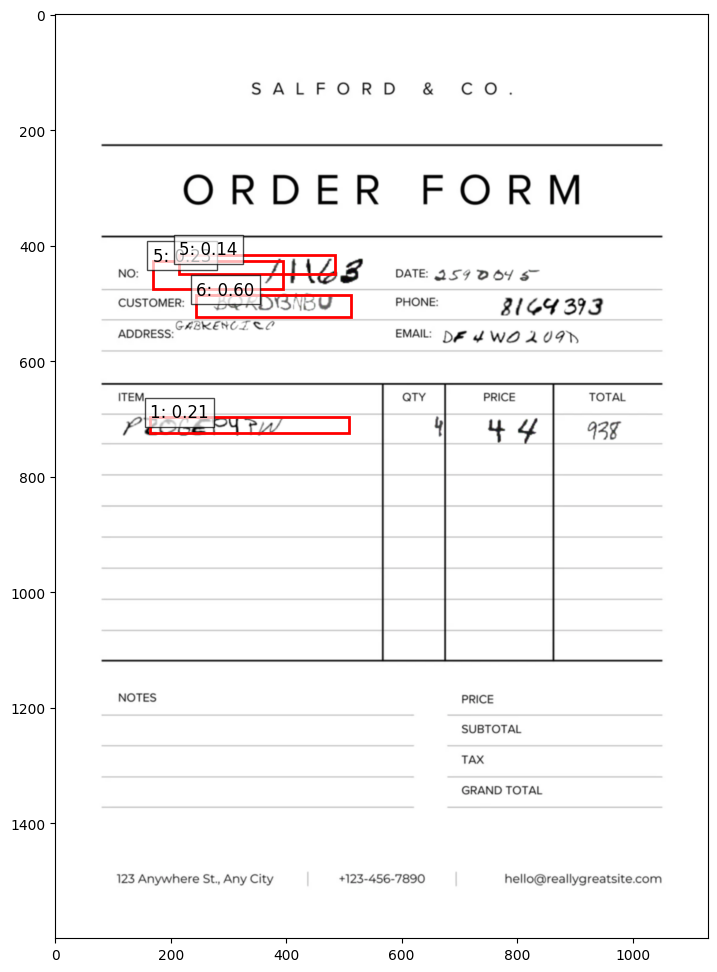

In [100]:
process_document(trained_model, image, device, confidence_threshold=0.1)

In [54]:
train_dataset.classes

{'Item 1': 1,
 'Date': 2,
 'Quantity 1': 3,
 'Total 1': 4,
 'Number': 5,
 'Customer': 6,
 'Phone': 7,
 'Price 1': 8,
 'Email': 9,
 'Address': 10}

## Real Image

In [93]:
import cv2

In [94]:
def align_to_template(image, template):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    orb = cv2.SIFT_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(template_gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_SL2)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches = sorted(matches, key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    num_good_matches = int(len(matches) * 0.15)
    matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = template_gray.shape
    registered_image = cv2.warpPerspective(image, h, (width, height))

    return registered_image

In [95]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_1.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [96]:
registered_image = align_to_template(image, template)
registered_image = Image.fromarray(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))

Boxes: [[169.09181 423.00815 396.01724 471.89005]
 [135.87231 696.9215  497.735   724.     ]
 [218.10199 415.99078 484.87253 450.4562 ]
 [266.98074 426.43365 504.8358  460.27475]
 [148.8178  389.08026 512.      476.36453]]
Scores: [0.18327433 0.1273529  0.1012964  0.08460017 0.06198521]


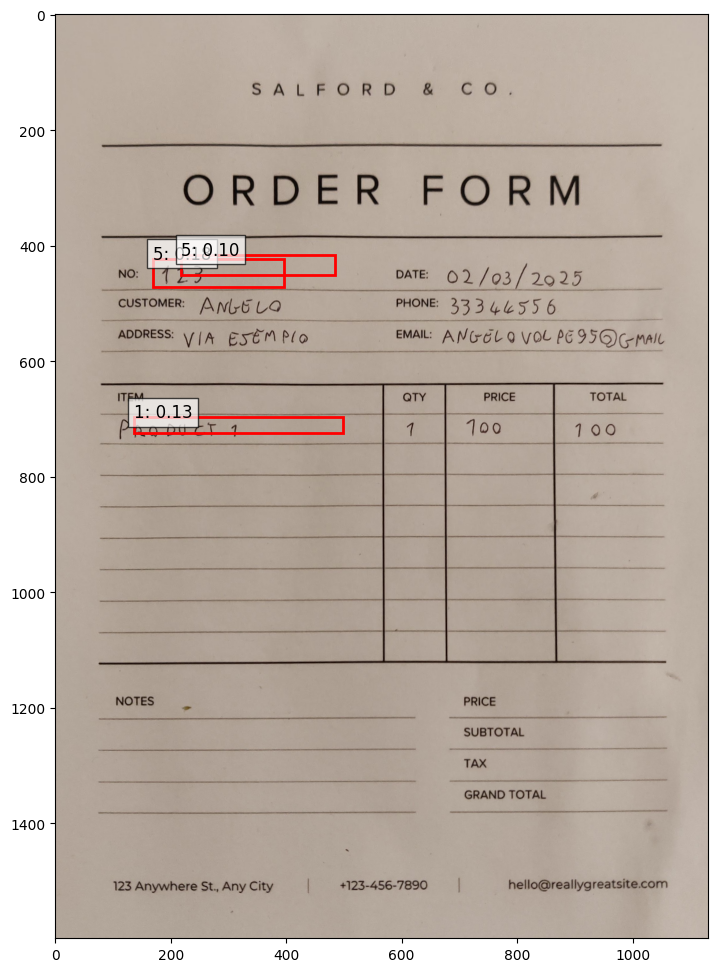

In [98]:
process_document(trained_model, registered_image, device, confidence_threshold=0.1)